In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
import time
import subprocess
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

In [2]:
def process_exists(process_name):
    call = 'TASKLIST', '/FI', 'imagename eq %s' % process_name
    # use buildin check_output right away
    output = subprocess.check_output(call).decode()
    # check in last line for process name
    last_line = output.strip().split('\r\n')[-1]
    # because Fail message could be translated
    return last_line.lower().startswith(process_name.lower())

def Run_Matlab(folder="mul_channel",printing=True):
    command = '\""C:\\Program Files\\MATLAB\\R2018a\\bin\\matlab.exe\" -nodisplay -nosplash -nodesktop -r \"main_kilosort1; exit\""'
    cwd = os.getcwd()
    os.chdir(cwd)
    os.chdir(folder)
    
    if printing:
        print("Running KiloSort")
    
    os.system("start /wait cmd /c {}".format(command))
    os.chdir(cwd)
    time.sleep(5)

    while (process_exists('MATLAB.exe')):
            time.sleep(2)
            if printing:
                print("KiloSort is still running...", end="\r")
    if printing:
        print("KiloSort is done")
            
    return 

def Run_Cpp(startfile = r"C:\Users\Bram\Documents\TU\Master\MEP\onlinespikesorter\x64\Debug\OnlineSpikes.exe",printing=True):

    #Run Program 
    os.startfile(startfile)
    if printing:
        print("Running OnlineSpikes...")
    
    #Check if program is running
    while (process_exists('OnlineSpikes.exe')):
        time.sleep(2)
        if printing:
            print("OnlineSpikes is still running...", end="\r")
    
    if printing:
        print("\nOnlineSpikes is done")
    time.sleep(2)
    
    return
    

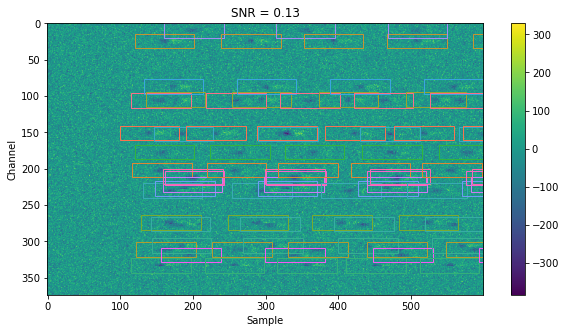

In [53]:
#Single Run
folder = "mul_channel"
startfile = r"C:\Users\Bram\Documents\TU\Master\MEP\onlinespikesorter\x64\Debug\OnlineSpikes.exe"

N = int(2.5e4)          #Amount of time samples
sampling_rate = 30000   #Sampling rate
C = 374                 #Number of channels
T = 20                  #Number of Templates
K = 82                  #Samples/template
noise_lvl = 0.35         #Amount of noise added
Gain = 200              #Amount of gain when converting to int16
lam = 1                #Amount of spikes/time length
reduce = 500            #Amount of spikes total is N divided by reduce
OKrange = 3

#Generate Rawfile which has to be sorted with ground truth arrays
RawFile, Spike_Index, Spike_Kind, Templates, ceny, SNR, avg_spike_rate = generate_data(N,C,T,K,
                        noise_lvl,Gain,lam,reduce,save=True,norm_temp=True,prefab=True,sampling_rate=sampling_rate)

#Show Rawfile and boxes around spikes that have to be found
Show_RawFile(RawFile,Spike_Index,Spike_Kind,ceny,xrange=600,SNR=SNR,labels=False)

# #Run KS
# Run_Matlab(folder=folder,printing=True)

# #First check how KS performs, if optimal merges are used
# KSGood, KSF_pos, KSMiss, KSDiff_spike = CheckKS(K,T,Templates, Spike_Index,Spike_Kind,
#                                         OKrange=OKrange,folder = folder,ratio=True, printing=False)

# #Take best templates from KS
# Temps = KS_to_online_temps(T,Templates)

# #Run templates gotten from KS through onlinesorter
# Run_Cpp(startfile = startfile,printing=True)

# #Check resuls from online sorter
# Good, F_pos, Miss, Diff_spike, Found_Index, Found_Kind, Spike_Index, Spike_Kind,\
#             Gotten, F_pstvs, Missed, Diff_Spikes = Check_out_to_in3(Spike_Index,
#                                                       Spike_Kind,OKrange=OKrange,printing = True)

# #Show results, Green = Good, Blue = wrong spike found, Yellow = False positive and Red = Missed
# Show_results(RawFile,Gotten, Diff_Spikes, F_pstvs, Missed, Found_Index,Found_Kind,
#               Spike_Index, Spike_Kind,ceny,xrange=600)


In [59]:
lams = [1,5,10,15,20,40,60,80,100,200]
SNR, G, F, M, D, KSG, KSF, KSM, KSD, avg_spike_rate = ([[] for _ in range(len(lams))] for _ in range(10)) 



In [102]:
#Multiple Runs

#main program
folder = "mul_channel"
startfile = r"C:\Users\Bram\Documents\TU\Master\MEP\onlinespikesorter\x64\Debug\OnlineSpikes.exe"

N = int(2.5e4)                         #Amount of time samples
C = 374                                #Number of channels
T = 25                                 #Number of Templates
K = 82                                 #Samples/template
noise_lvl = 0.35                      #Noise added
Gain = 200                             #Amount of gain when converting to int16
lams = [1,5,10,15,20,40,60,80,100,200]    #Amount of spikes/time length
reduce = 500                           #Amount of spikes total is N divided by reduce
times = 1
OKrange = 4


print("Starting...")
for it, lam in enumerate(lams):
    print("\nIteration {}".format(it))
    for jt in range(times):
        print("Running session {}...".format(jt),end="\r")
        SNRt, Gt, Ft, Mt, Dt,\
        KSGt, KSFt, KSMt, KSDt, avg_spike_ratet = full_run(N,C,T,K,noise_lvl,
                            Gain,lam,reduce,folder,OKrange=OKrange,
                                    save=True,norm_temp=True,prefab=True,show=False,printing=False)
        
        SNR[it].append(SNRt)
        G[it].append(Gt)
        F[it].append(Ft)
        M[it].append(Mt)
        D[it].append(Dt)
        KSG[it].append(KSGt)
        KSF[it].append(KSFt)
        KSM[it].append(KSMt)
        KSD[it].append(KSDt)
        avg_spike_rate[it].append(avg_spike_ratet)
        

print("\nDone")
    




Starting...

Iteration 0
Running session 0...
Iteration 1


KeyboardInterrupt: 

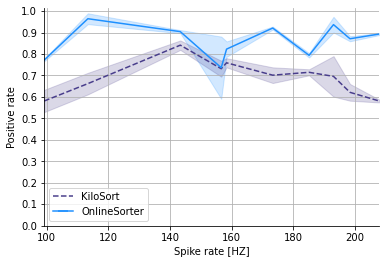

In [104]:
lams = [1,5,10,15,20,40,60,80,100]
#T = 25; #Noise = 0.35


MSNR = np.array([np.mean(x) for x in SNR])
SSNR = np.array([np.std(x,ddof=1)/len(x) for x in SNR])

MHZ = np.array([np.mean(x) for x in avg_spike_rate])
SHZ = np.array([np.std(x,ddof=1)/len(x) for x in avg_spike_rate])

Brate =  [ [i[x] + j[x] + k[x] for x in range(len(i))] for i,j,k in zip(F,D,M)]
Grate = G

KSBrate = [ [i[x] + j[x] + k[x] for x in range(len(i))] for i,j,k in zip(KSF,KSD,KSM)]
KSGrate = KSG

MGrate = np.array([np.mean(x) for x in Grate])
SGrate = np.array([np.std(x,ddof=1)/len(x) for x in Grate])

MBrate = np.array([np.mean(x) for x in Brate])
SBrate = np.array([np.std(x,ddof=1)/len(x) for x in Brate])

MKSGrate = np.array([np.mean(x) for x in KSGrate])
KSSGrate = np.array([np.std(x,ddof=1)/len(x) for x in KSGrate])

MKSBrate = np.array([np.mean(x) for x in KSBrate])
KSSBrate = np.array([np.std(x,ddof=1)/len(x) for x in KSBrate])


inds = np.argsort(MHZ)

MHZ = MHZ[inds]
MGrate = MGrate[inds]
SGrate = SGrate[inds]
MKSGrate = MKSGrate[inds]
KSSGrate = KSSGrate[inds]


plt.figure()
plt.errorbar(MHZ, MGrate, xerr=0,  color='dodgerblue',label="OnlineSorter")
plt.plot(MHZ, MKSGrate, color='darkslateblue',linestyle='--',label="KiloSort")

plt.fill_between(MHZ, MGrate  + SGrate, MGrate - SGrate, color = 'dodgerblue',alpha = 0.2)
plt.fill_between(MHZ, MKSGrate  + KSSGrate, MKSGrate - KSSGrate,color = "darkslateblue",alpha = 0.2)


plt.yticks(np.linspace(0,1,11))

plt.gca().spines['right'].set_color('None')
plt.gca().spines['top'].set_color('None')

#plt.xticks(np.linspace(0,1,11))
plt.xlim(min(MHZ),max(MHZ))
#plt.ylim(0,1)
plt.grid()
plt.ylabel("Positive rate")
plt.xlabel("Spike rate [HZ]")
plt.legend()
plt.show()


In [3]:
def full_run(N,C,T,K,noise_lvl,Gain,lam,reduce,
             folder="mul_channel",OKrange=3,save=True,norm_temp=True,prefab=True,show=True,printing=False):
   
    #Generate data
    RawFile, Spike_Index, Spike_Kind, Templates, ceny, SNR, avg_spike_rate = generate_data(N,C,T,K,
                            noise_lvl,Gain,lam,reduce,save=True,norm_temp=True,prefab=True)
    if show:
        Show_RawFile(RawFile,Spike_Index,Spike_Kind,ceny,xrange=700,SNR=SNR,labels=False)
    
    #Run it with matlab
    Run_Matlab(folder=folder,printing=printing)
    
    #First check how KS performs, if optimal merges are used
    KSGood, KSF_pos, KSMiss, KSDiff_spike = CheckKS(K,T,Templates, Spike_Index,Spike_Kind,
                                            OKrange=OKrange,folder = folder,ratio=True, printing=False)
    
    #Take best templates from KS
    Temps = KS_to_online_temps(T,Templates)

    #Run templates gotten from KS through onlinesorter
    Run_Cpp(startfile = startfile,printing = printing)
    
    #Check resuls from online sorter
    Good, F_pos, Miss, Diff_spike, Found_Index, Found_Kind,\
    Spike_Index, Spike_Kind, Gotten, F_pstvs, Missed, Diff_Spikes = Check_out_to_in3(Spike_Index,
                                            Spike_Kind,OKrange=OKrange, printing = printing)
    
    if show:
        #Show results, Green = Good, Blue = wrong spike found, Yellow = False positive and Red = Missed
        Show_results(RawFile,Gotten, Diff_Spikes, F_pstvs, Missed, Found_Index,Found_Kind,
                 Spike_Index, Spike_Kind,ceny,xrange=600)
        
    return SNR, Good, F_pos, Miss, Diff_spike, KSGood, KSF_pos, KSMiss, KSDiff_spike, avg_spike_rate


In [4]:
def generate_train(T,K,lam,N,reduce,sampling_rate=30000):
    '''Generate spike train indeces for multiple spikes'''
    
    P = int(N/reduce)

    Spike_Index = np.array([],dtype=int)
    Spike_Kind  = np.array([],dtype=int)
    
    #Loop over amount of Templates
    for i in range(T):
        Kind  = np.ones(P,dtype=int) * i
        
        lam = lam + int(np.random.normal()*10)
        
        Index = np.random.poisson(size=P, lam = 5)  + 0.0005 * sampling_rate + K + lam
        Index = np.cumsum(Index).astype(int)  + int(np.random.randint(0,T))  
        
        Spike_Index = np.concatenate((Spike_Index,Index))
        Spike_Kind = np.concatenate((Spike_Kind,Kind))
    

    sort = np.argsort(Spike_Index)
    
    Spike_Index = Spike_Index[sort]
    Spike_Kind  = Spike_Kind[sort]
    
    Spike_Kind  = Spike_Kind[Spike_Index <= (N - K//2)]
    Spike_Index = Spike_Index[Spike_Index <= (N - K//2)]
    
    avg_spike_rate = sampling_rate / (np.max(Spike_Index) / P) 
    
    return Spike_Index, Spike_Kind, avg_spike_rate



In [5]:
def generate_data(N,C,T,K,noise_lvl=0.001,Gain=250,
                  lam=80,reduce=250,save=True,norm_temp=True,prefab=False,crop = True,sampling_rate=30000):

    #Generate random indeces spaced with poisson distribution
    Spike_Index , Spike_Kind,avg_spike_rate = generate_train(T,K,lam,N,reduce,sampling_rate)

    RawFile, Templates, Whitening, ChanMap, ceny = make_Files(T,K,C,Spike_Index,Spike_Kind,norm_temp,prefab)

    #Add noise
    noise =  np.random.normal(size=RawFile.shape) * noise_lvl
    RawFile += noise
    
    if noise_lvl != 0:
        #SNR = 20 * np.log10(np.linalg.norm(RawFile - noise) / np.linalg.norm(noise)) 
        SNR = np.linalg.norm(RawFile - noise) / np.linalg.norm(noise)
    else:
        SNR = np.inf
    
    if crop:
        end = np.max(Spike_Index)
        RawFile = RawFile[:,0:end + K]
        N = end + K
    
    RawFile = RawFile * Gain
    
    #Convert to int
    RawFileint = RawFile.astype('i2')
    RawFileint = RawFileint.flatten('F')
    

    if save:
        #Save files
        RawFileint.tofile(os.path.join(folder,'RawFile.bin'))
        np.save(os.path.join(folder,'templates.npy'),    Templates)
        np.save(os.path.join(folder,'whitening_mat.npy'),Whitening)
        np.save(os.path.join(folder,'channel_map.npy'),  ChanMap)
          
    RawFileint = np.reshape(RawFileint,(C,N),order= 'F')


    
    return RawFileint, Spike_Index, Spike_Kind, Templates, ceny, SNR, avg_spike_rate


In [6]:
def make_Files(T,K,C,Spike_Index,Spike_Kind,norm_temp,prefab):
    #Generate empty arrays
    Templates = np.zeros(shape=(T,K,C),dtype=np.float32, order='F') 
    Whitening = np.zeros(shape=(C,C)  ,dtype=np.double)
    RawFile =   np.zeros(shape=(C,N))
    ChanMap =   np.zeros(shape=(C,1)  ,dtype=np.int32)
    
    #Generate whitening and chanmap
    Whitening = np.eye(ChanMap.shape[0])
    
    ChanMap[:,0] = np.int32(np.arange(C))
    ceny = np.zeros(T,dtype = int)
     
    if prefab:
        prefab_temps = np.load('templates_prefab.npy')
        Ctemp = prefab_temps.shape[2]
        A = np.random.choice(64,size = T, replace = False)
        B = np.random.randint(low = 0,high = C - Ctemp , size=T)   
        
        for i in range(T):
            Templates[i,:,B[i]:B[i] + Ctemp] = prefab_temps[A[i],:,:]
            ceny[i] = np.argmax(np.std(Templates[i,:,:].T ,axis=1 ,ddof=1))
            
    else:
        #make templates
        for i in range(T):
            Template, cenytemp = gen_rand_spike(K,C,norm_temp)
            Templates[i,:,:] = np.transpose(Template)
            ceny[i] = cenytemp
        
    if norm_temp:
        Amp = np.random.random(size=T)/2 + 4
        
    else:
        Amp = np.ones(T)

    for index,kind in zip(Spike_Index,Spike_Kind):
        #RawFile[:,index-K//2:index + K//2] += Amp[kind] * Templates[kind,:,:].T
        RawFile[:,index:index+K] += Amp[kind] * Templates[kind,:,:].T
         
    return RawFile, Templates, Whitening, ChanMap, ceny

In [7]:
def gen_rand_spike(K,C,norm_temp):
    #Generate random center
    cenx = K//2
    ceny = np.random.randint(low= 0 ,high = C)
    x = np.arange(0,K); y = np.arange(0,C)
    
    #Generate meshgrid
    x,y = np.meshgrid(x,y)
    r = np.sqrt((x-cenx)**2 + (y-ceny)**2)
    
    #Number of functions the signal exists out of
    N = 3

    signal = np.zeros((C,K))
    for i in range(N):
        if i == 0:
            freq = np.random.random()
            signal += np.random.random() * np.sin(freq*r*15*np.pi/K)
        signal += np.random.random()*r**np.random.random()
        
    mu = np.random.random() * 0.25 + 0.5
    Spike = signal * np.exp(-r * mu)
    Spike[x < cenx] = 0
    
    if norm_temp:
        Spike = Spike/np.sqrt(np.sum(Spike**2))
    

    return Spike, ceny

# Spike = gen_rand_spike(40,50)

# plt.imshow(Spike)
# plt.show()

In [8]:
def Show_RawFile(RawFile,Spike_Index, Spike_Kind,ceny,xrange=700,SNR=None,labels=False):
    plt.figure(figsize=(10,5))
    plt.imshow(RawFile[:,:xrange])
    
    if SNR != None:
        plt.title('SNR = {:.2f}'.format(SNR))

    ax = plt.gca()
    clrs = sns.color_palette('husl', n_colors=T)

    for index, kind in zip(Spike_Index, Spike_Kind):
        col = clrs[kind]

        rect = Rectangle((index, ceny[kind]-10),K,20,
                         linewidth = 1, facecolor= 'none', edgecolor= col, label= "Spike: {}".format(kind))
        ax.add_patch(rect)

    if labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))

        plt.legend(by_label.values(), by_label.keys())
        
    plt.ylabel('Channel')
    plt.xlabel('Sample')
        
    plt.colorbar()

    plt.show()
    
    return 

In [9]:
def Show_results(RawFile,Gotten, Diff_Spikes, F_pstvs, Missed, Found_Index,
                 Found_Kind, Spike_Index, Spike_Kind,ceny,xrange=600):
    plt.figure(figsize=(10,5))
    plt.imshow(RawFile[:,:xrange])
    plt.title('Window size 300')
    
    ax = plt.gca()
    
    for index, kind in zip(Found_Index, Found_Kind):
        if index in Gotten:
            col = (0,1,0)
            offset = 0
            
        elif index in Diff_Spikes:
            col = (0,0,1)
            offset = 3
            
        elif index in F_pstvs:
            col = (1,1,0)
            offset = 2
            
        else:
            #This shouldn't happen
            col = (1,0,0)
            offset = 1
            
        rect = Rectangle((index + offset, ceny[kind]-10),K,20,
                         linewidth = 1, facecolor= 'none', edgecolor= col, label= "Spike: {}".format(kind))
        
        ax.add_patch(rect)
        
    for spike in Missed:
        indexx = np.where(Spike_Index == spike)
        for index in indexx[0]:
            kind = Spike_Kind[index]
            time = Spike_Index[index]
            col = (1, 0, 0)
            rect = Rectangle((time, ceny[kind]-10),K,20,
                             linewidth = 1, facecolor= 'none', edgecolor= col, label= "Spike: {}".format(kind))
            ax.add_patch(rect) 
        
    plt.show()
    
    return



In [10]:
def get_ratio(Good, F_pos, Miss, Diff_spike):
    Tot = Good + F_pos + Miss + Diff_spike

    Good = Good/Tot
    F_pos = F_pos/Tot
    Miss = Miss/Tot
    Diff_spike = Diff_spike/Tot
    
    return Good, F_pos, Miss, Diff_spike


def get_output(folder="mul_channel"):
    #Import
    Found = np.genfromtxt(folder + r'/spike_output.csv',delimiter=',')

    #Convert to integers
    Found_Index = Found[:,0].astype(int) - 1 #To correct between program and data
    Found_Kind  = Found[:,1].astype(int)
    Found_Amps  = Found[:,2].astype(float)
    
    return Found_Index, Found_Kind, Found_Amps
    

def Check_out_to_in3(Spike_Index, Spike_Kind,
                     OKrange = 3,printing = False,
                     folder="mul_channel",Found_Index = None, Found_Kind = None,ratio=True):
    
    if Found_Index is None:
        Found_Index, Found_Kind, _ = get_output(folder="mul_channel")

    sort = np.argsort(Found_Index)
    
    Found_Index = Found_Index[sort]
    Found_Kind  = Found_Kind[sort]

    Spike_Index_corr = Spike_Index[Spike_Index <= max(Found_Index)]  
    Spike_Kind_corr  = Spike_Kind[Spike_Index <= max(Found_Index)]

    
    if printing:
        N = int(100)
        print("Just showing first {}".format(N))
        print('-----------------Indeces Found (' + str(len(Found_Index)) + '):------------------------------')
        print(*zip(Found_Index[:N],Found_Kind[:N]))
        print('\n-----------------Indeces that should\'ve been found (' + str(len(Spike_Index_corr)) + 
              '):------------')
        print(*zip(Spike_Index_corr[:N],Spike_Kind_corr[:N]))

    Good        = 0
    F_pos       = 0
    Miss        = 0
    Diff_spike  = 0

    Removed1 = 0
    Removed2 = 0
    
    Gotten      = []
    F_pstvs     = []
    Missed      = []
    Diff_Spikes = []
    
    Leftover_Index = np.copy(Spike_Index_corr)
    Leftover_Kind  = np.copy(Spike_Kind_corr)
    
    Found_Index_copy = np.copy(Found_Index)
    Found_Kind_copy = np.copy(Found_Kind)
    
    for index, kind  in zip(Found_Index, Found_Kind):

        psblts = np.arange(-OKrange, OKrange + 1) + index
      
        for possible in psblts:

            if possible in Leftover_Index and np.any(Leftover_Kind[Leftover_Index == possible] == kind):
                
                Good = Good + 1
                Gotten.append(index)
                
                Remove1 = np.where(Leftover_Index == possible)[0]
                
                for i in range(len(Remove1)):
                    if kind == Leftover_Kind[Remove1[i]]:
                        Removed1 = Remove1[i]
                        break
                        
                Remove2 = np.where(Found_Index_copy == index)[0]
                
                for i in range(len(Remove2)):
                    if kind == Found_Kind_copy[Remove2[i]]:
                        Removed2 = Remove2[i]
                        break
                        
                Leftover_Index = np.delete(Leftover_Index,Removed1)
                Leftover_Kind  = np.delete(Leftover_Kind, Removed1)
                
                Found_Index_copy = np.delete(Found_Index_copy, Removed2)
                Found_Kind_copy  = np.delete(Found_Kind_copy, Removed2)
    
                break
        
        
    
    for index, kind  in zip(Found_Index_copy, Found_Kind_copy):
        if len(Leftover_Index) == 0:
            F_pos = F_pos + 1
            F_pstvs.append(index)
            continue
            
        psblts = np.arange(-OKrange, OKrange + 1) + index  
        
        Diff = False
        for possible in psblts:
            if possible in Leftover_Index and np.all(Leftover_Kind[Leftover_Index == possible] != kind):
                Diff_spike = Diff_spike + 1
                Diff_Spikes.append(index)
                Diff = True
                
                #Remove
                Remove = np.where(Leftover_Index == possible)[0]
                
                for i in range(len(Remove)):
                    if kind != Leftover_Kind[Remove[i]]:
                        Removed = Remove[i]
                        break

                Leftover_Index = np.delete(Leftover_Index, Removed)
                Leftover_Kind  = np.delete(Leftover_Kind,  Removed)
                
                Diff = True
                break
        
        if not Diff:
            F_pos = F_pos + 1
            F_pstvs.append(index)
  
    Missed = list(Leftover_Index)
    Miss = len(Missed)

        
    if printing:
        print("\n# Correctly found: {}, # False positives {}, # Missed: {} and Wrongly assigned: {}\n".
            format(Good,F_pos,Miss, Diff_spike))
        print("---- Spikes gotten correctly (" + str(Good) + "): -----\n",*Gotten[:50])
        print("\n---- False positives (" + str(F_pos) + "): -----\n",*F_pstvs[:50])
        print("\n---- Missed Spikes (" + str(Miss) + "): -----\n", *Missed[:50])
        print("\n---- Assigned the wrong spike (" + str(Diff_spike) + "): ----\n", *Diff_Spikes[:50])

    if ratio:
        Good, F_pos, Miss, Diff_spike = get_ratio(Good, F_pos, Miss, Diff_spike)
        
    return Good, F_pos, Miss, Diff_spike, Found_Index, Found_Kind, Spike_Index, Spike_Kind,\
            Gotten, F_pstvs, Missed, Diff_Spikes


# Good, F_pos, Miss, Diff_spike,\
# Found_Index, Found_Kind, Spike_Index, Spike_Kind,Gotten, F_pstvs, Missed, Diff_Spikes = Check_out_to_in3(
#     Spike_Index, Spike_Kind,OKrange=5, printing = True)


# Show_results(RawFile,Gotten, Diff_Spikes, F_pstvs, Missed, Found_Index,Found_Kind,
#              Spike_Index, Spike_Kind,ceny,xrange=700)



# print(Spike_Kind[Spike_Index == 60])


In [11]:
#Run this first to reduce 'useless' templates

def MSE(A,B):
    return np.sum(np.square(np.subtract(A, B)), axis=None)

def KS_to_online_temps(T, Templates,folder= "mul_channel",KS_version = 1,Heatmap=False,whitening=False):
    KStemplates = np.load(os.path.join(folder,'templates.npy'))
    Whitening = np.load(os.path.join(folder, 'whitening_mat.npy'))
    
    
    numKStemps = KStemplates.shape[0]
    #foundcen = np.argmin(np.min(KStemplates, axis = 1), axis = 1)
    #Whitening_Inv = np.load(os.path.join(folder, 'whitening_mat_inv.npy'))
    
    
    MSE_mat = np.zeros((T,numKStemps))

    for i in range(T):
        for j in range(numKStemps):
            MSE_mat[i,j] = MSE(Templates[i,:,:],KStemplates[j,:,:])

    if Heatmap:
        MSE_mat =  MSE_mat/np.linalg.norm(MSE_mat,axis=1,ord=1)[:,None]
        figsize = tuple(np.array([numKStemps,T])//5)
        plt.figure(figsize=figsize)      
        sns.heatmap(MSE_mat,linewidth= .5, cmap="PiYG")
        plt.show()

        
    #--------------------
    Temps = np.zeros(shape=(T,K,C),dtype=np.float32, order='F')
    ChanMap =   np.zeros(shape=(C,1)  ,dtype=np.int32)
    
    if not whitening:
        Whitening = np.zeros(shape=(C,C)  ,dtype=np.double)
        Whitening = np.eye(ChanMap.shape[0]) 
        np.save(os.path.join(folder,'whitening_mat.npy'),Whitening)

    
    ChanMap[:,0] = np.int32(np.arange(C))


    mins = np.argmin(MSE_mat,axis = 1)
    Temps = KStemplates[mins,:,:]
    Temps = np.asfortranarray(Temps)
    
    if KS_version == 3:
        Temps = gaussian_filter1d(Temps, sigma = 2 , axis = 1)

    
    np.save(os.path.join(folder,'templates.npy'),Temps)
    np.save(os.path.join(folder,'channel_map.npy'),  ChanMap)
    #--------------------

    
    return Temps



#B = KS_to_online_temps(T, Templates,folder= "mul_channel",KS_version = 1,Heatmap=True,whitening=True)


In [15]:
def CheckKS(K,T,Templates, Spike_Index, Spike_Kind,OKrange= 4, folder="mul_channel", printing=False,ratio = True):
    KS_Index = np.squeeze(np.load(os.path.join(folder,"spike_times.npy"))) - K//2
    KS_Kind  = np.squeeze(np.load(os.path.join(folder,"spike_clusters.npy")))

    uni = np.unique(KS_Kind)
    Nuni = len(uni)

    Temps = np.load(os.path.join(folder,'templates.npy'))
    Temps = Temps[uni,:,:]

    MSE_mat = np.empty((T,Nuni))

    for i in range(T):
        for j in range(Nuni):
            MSE_mat[i,j] = MSE(Templates[i,:,:],Temps[j,:,:])

    mins1 = np.argmin(MSE_mat,axis = 1)
    KSTemps = Temps[mins1,:,:]

    mins2 = np.argmin(MSE_mat,axis=0)
    KS_Kind_new = np.empty(KS_Kind.shape,dtype=int)

    for i in range(Nuni):
        KS_Kind_new[KS_Kind == uni[i]] = mins2[i]
        
    Good, F_pos, Miss, Diff_spike,\
    Found_Index, Found_Kind, Spike_Index, Spike_Kind,Gotten, F_pstvs, Missed, Diff_Spikes = Check_out_to_in3(
        Spike_Index, Spike_Kind, OKrange=OKrange, printing = printing,
        Found_Index = KS_Index, Found_Kind = KS_Kind_new )    
    
    return Good, F_pos, Miss, Diff_spike

#Good, F_pos, Miss, Diff_spike = CheckKS(K,T,Templates, Spike_Index, Spike_Kind)

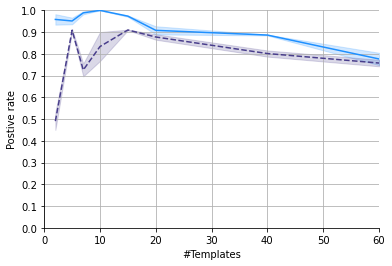

In [56]:

##Different Templates
T = [2, 5, 7, 10, 15, 20, 40, 60]

SNR = [[1.3339751566425444, 1.412537043719211, 1.3228038532281072], [2.2119825301723983, 2.233100580155886, 2.1926784496907312], [2.59277700499156, 2.55956579643246, 2.636230941756435], [3.0930612382764626, 3.1132166000357038, 3.0309648468982995], [3.8397137672198083, 3.8558453174225247, 3.7587639961097157], [4.513973500147975, 4.3857400275261265, 4.364957752817926], [6.243539264036653, 6.22602391130858, 6.283098701992343], [7.674153041622445, 7.648733178650955, 7.674244750312474]]
G = [[1.0, 0.875, 1.0], [0.9444444444444444, 1.0, 0.9090909090909091], [0.9655172413793104, 1.0, 1.0], [1.0, 1.0, 1.0], [0.9838709677419355, 0.9705882352941176, 0.9655172413793104], [0.8666666666666667, 0.8857142857142857, 0.9719626168224299], [0.8862275449101796, 0.8807947019867549, 0.8923076923076924], [0.8028846153846154, 0.8454106280193237, 0.6812749003984063]]
F = [[0.0, 0.125, 0.0], [0.05555555555555555, 0.0, 0.045454545454545456], [0.034482758620689655, 0.0, 0.0], [0.0, 0.0, 0.0], [0.016129032258064516, 0.014705882352941176, 0.017241379310344827], [0.08, 0.014285714285714285, 0.009345794392523364], [0.017964071856287425, 0.006622516556291391, 0.023076923076923078], [0.004807692307692308, 0.004830917874396135, 0.00398406374501992]]
M = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.045454545454545456], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.014705882352941176, 0.017241379310344827], [0.05333333333333334, 0.04285714285714286, 0.018691588785046728], [0.023952095808383235, 0.039735099337748346, 0.05384615384615385], [0.12980769230769232, 0.12560386473429952, 0.2788844621513944]]
D = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.05714285714285714, 0.0], [0.0718562874251497, 0.0728476821192053, 0.03076923076923077], [0.0625, 0.024154589371980676, 0.035856573705179286]]




KSG = [[0.35148514851485146, 0.5679012345679012, 0.5522388059701493], [0.8897338403041825, 0.9260700389105059, 0.909433962264151], [0.8275862068965517, 0.6748971193415638, 0.675], [0.6031746031746031, 0.954183266932271, 0.9434697855750487], [0.9050715214564369, 0.9118387909319899, 0.912532637075718], [0.9063745019920318, 0.8349802371541502, 0.8911968348170128], [0.7758537758537759, 0.7780536246276067, 0.8504168710152036], [0.7842942345924453, 0.783311345646438, 0.7055888223552894]]
KSF = [[0.504950495049505, 0.3888888888888889, 0.2537313432835821], [0.049429657794676805, 0.027237354085603113, 0.05660377358490566], [0.13793103448275862, 0.27983539094650206, 0.2708333333333333], [0.3386243386243386, 0.00398406374501992, 0.025341130604288498], [0.0247074122236671, 0.055415617128463476, 0.020887728459530026], [0.00398406374501992, 0.011857707509881422, 0.010880316518298714], [0.037999037999038, 0.007447864945382324, 0.019127023050514957], [0.005964214711729622, 0.010554089709762533, 0.001996007984031936]]
KSM = [[0.13861386138613863, 0.043209876543209874, 0.19402985074626866], [0.03802281368821293, 0.04669260700389105, 0.033962264150943396], [0.03201970443349754, 0.04526748971193416, 0.0375], [0.037037037037037035, 0.04183266932270916, 0.031189083820662766], [0.07022106631989597, 0.031486146095717885, 0.06657963446475196], [0.08764940239043825, 0.10474308300395258, 0.08506429277942631], [0.13612313612313612, 0.1708043694141013, 0.10642471799901913], [0.19218025182239895, 0.18733509234828497, 0.2767797737857618]]
KSD = [[0.0049504950495049506, 0.0, 0.0], [0.022813688212927757, 0.0, 0.0], [0.0024630541871921183, 0.0, 0.016666666666666666], [0.021164021164021163, 0.0, 0.0], [0.0, 0.0012594458438287153, 0.0], [0.00199203187250996, 0.04841897233201581, 0.012858555885262116], [0.050024050024050026, 0.04369414101290963, 0.024031387935262383], [0.01756129887342611, 0.018799472295514513, 0.015635395874916833]]


MSNR = np.array([np.mean(x) for x in SNR])
SSNR = np.array([np.std(x,ddof=1)/len(x) for x in SNR])

MT = np.array([np.mean(x) for x in T])

Brate =  [ [i[x] + j[x] + k[x] for x in range(len(i))] for i,j,k in zip(F,D,M)]
Grate = G

KSBrate = [ [i[x] + j[x] + k[x] for x in range(len(i))] for i,j,k in zip(KSF,KSD,KSM)]
KSGrate = KSG

MGrate = np.array([np.mean(x) for x in Grate])
SGrate = np.array([np.std(x,ddof=1)/len(x) for x in Grate])

MBrate = np.array([np.mean(x) for x in Brate])
SBrate = np.array([np.std(x,ddof=1)/len(x) for x in Brate])

MKSGrate = np.array([np.mean(x) for x in KSGrate])
KSSGrate = np.array([np.std(x,ddof=1)/len(x) for x in KSGrate])

MKSBrate = np.array([np.mean(x) for x in KSBrate])
KSSBrate = np.array([np.std(x,ddof=1)/len(x) for x in KSBrate])


plt.figure()

plt.plot(MT, MGrate,   color='dodgerblue',label="OnlineSorter")
plt.plot(MT, MKSGrate, color='darkslateblue',linestyle='--',label="KiloSort")


plt.fill_between(MT, MGrate  + SGrate, MGrate - SGrate, color = 'dodgerblue',alpha = 0.2)
plt.fill_between(MT, MKSGrate  + KSSGrate, MKSGrate - KSSGrate,color = 'darkslateblue',alpha = 0.2)

plt.gca().spines['right'].set_color('None')
plt.gca().spines['top'].set_color('None')

plt.yticks(np.linspace(0,1,11))
plt.grid()
plt.xlim(0,60)
plt.ylim(0,1)
plt.ylabel("Postive rate")
plt.xlabel("#Templates")
#plt.legend()
plt.show()



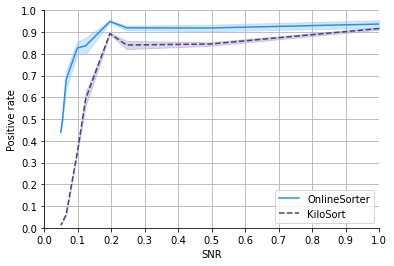

In [55]:
#Different noise lvls   T = 25
SNR = [[1, 1, 1], [0.5017748217621312, 0.49459816531894407, 0.4873745747435485], [0.2489928033432573, 0.24421559650067953, 0.24475141888796376], [0.19694916507862192, 0.19611275019191676, 0.1956494914782599], [0.12253315869930759, 0.12561706255075838, 0.12391109087930406], [0.098945726499366, 0.09894403094737442, 0.09885105973531354], [0.06495285425352341, 0.06565418862826602, 0.06567804244196787], [0.05384218294960832, 0.0552639061613396, 0.0546981546749709], [0.04933872418308284, 0.04904565773406682, 0.05019686020193493]]
G  = [[0.9534883720930233, 0.8780487804878049, 0.979381443298969], [0.9026548672566371, 0.8842105263157894, 0.97], [0.920863309352518, 0.8878504672897196, 0.95], [0.9354838709677419, 0.9456521739130435, 0.9666666666666667], [0.8627450980392157, 0.7165354330708661, 0.9325842696629213], [0.9285714285714286, 0.7857142857142857, 0.7666666666666667], [0.6307692307692307, 0.8217821782178217, 0.5901639344262295], [0.4971751412429379, 0.4943820224719101, 0.49710982658959535], [0.4519774011299435, 0.4143646408839779, 0.455026455026455]]
F = [[0.023255813953488372, 0.024390243902439025, 0.010309278350515464], [0.02654867256637168, 0.042105263157894736, 0.02], [0.03597122302158273, 0.018691588785046728, 0.02], [0.016129032258064516, 0.03260869565217391, 0.025], [0.0196078431372549, 0.07874015748031496, 0.0449438202247191], [0.023809523809523808, 0.09183673469387756, 0.05], [0.34615384615384615, 0.1782178217821782, 0.30327868852459017], [0.4406779661016949, 0.4887640449438202, 0.44508670520231214], [0.4689265536723164, 0.569060773480663, 0.4021164021164021]]
M = [[0.023255813953488372, 0.06504065040650407, 0.010309278350515464], [0.035398230088495575, 0.05263157894736842, 0.01], [0.03597122302158273, 0.06542056074766354, 0.01], [0.016129032258064516, 0.010869565217391304, 0.008333333333333333], [0.029411764705882353, 0.12598425196850394, 0.02247191011235955], [0.03571428571428571, 0.061224489795918366, 0.09166666666666666], [0.015384615384615385, 0.0, 0.03278688524590164], [0.0, 0.0056179775280898875, 0.005780346820809248], [0.01694915254237288, 0.0055248618784530384, 0.06878306878306878]]
D = [[0.0, 0.032520325203252036, 0.0], [0.035398230088495575, 0.021052631578947368, 0.0], [0.007194244604316547, 0.028037383177570093, 0.02], [0.03225806451612903, 0.010869565217391304, 0.0], [0.08823529411764706, 0.07874015748031496, 0.0], [0.011904761904761904, 0.061224489795918366, 0.09166666666666666], [0.007692307692307693, 0.0, 0.07377049180327869], [0.062146892655367235, 0.011235955056179775, 0.05202312138728324], [0.062146892655367235, 0.011049723756906077, 0.07407407407407407]]

KSG = [[0.9258675078864353, 0.8979591836734694, 0.9250996015936255], [0.8360914105594957, 0.8255722178374112, 0.8736089030206677], [0.8275607958732498, 0.7907716785998409, 0.9038155802861685], [0.8825396825396825, 0.8892430278884462, 0.9075098814229249], [0.5180887372013652, 0.5602409638554217, 0.7019077901430842], [0.3695479777954005, 0.339171974522293, 0.3344500279173646], [0.05842185128983308, 0.0673374613003096, 0.053854875283446714], [0.024029574861367836, 0.031522468142186455, 0.023892483822797413], [0.011340623734305387, 0.007454739084132056, 0.02085561497326203]]
KSF = [[0.014195583596214511, 0.018838304552590265, 0.00398406374501992], [0.015760441292356184, 0.013417521704814523, 0.006359300476947536], [0.079587324981577, 0.005568814638027049, 0.007154213036565978], [0.007936507936507936, 0.004780876494023904, 0.011857707509881422], [0.14675767918088736, 0.16331994645247658, 0.006359300476947536], [0.008723235527359239, 0.007165605095541401, 0.30206588498045783], [0.05235204855842185, 0.039473684210526314, 0.29138321995464855], [0.422365988909427, 0.16230717639168343, 0.37779990044798406], [0.4937221547185095, 0.0, 0.3315508021390374]]
KSM = [[0.05914826498422713, 0.07378335949764521, 0.0701195219123506], [0.09062253743104808, 0.14601420678768745, 0.09618441971383147], [0.08916728076639646, 0.17501988862370724, 0.07233704292527822], [0.0880952380952381, 0.10119521912350597, 0.07430830039525692], [0.2764505119453925, 0.249665327978581, 0.2845786963434022], [0.6042823156225218, 0.6345541401273885, 0.34003350083752093], [0.8535660091047041, 0.8676470588235294, 0.5833333333333334], [0.5415896487985212, 0.7075788061703555, 0.5450472872075659], [0.4669906844876468, 0.9914802981895634, 0.6149732620320856]]
KSD = [[0.0007886435331230284, 0.009419152276295133, 0.0007968127490039841], [0.05752561071710008, 0.01499605367008682, 0.02384737678855326], [0.0036845983787767134, 0.028639618138424822, 0.016693163751987282], [0.02142857142857143, 0.004780876494023904, 0.006324110671936759], [0.05870307167235495, 0.02677376171352075, 0.007154213036565978], [0.017446471054718478, 0.01910828025477707, 0.023450586264656615], [0.03566009104704097, 0.025541795665634675, 0.07142857142857142], [0.012014787430683918, 0.09859154929577464, 0.053260328521652564], [0.027946537059538274, 0.0010649627263045794, 0.032620320855614976]]



SNR[0] = [1 for _ in range(len(SNR[0]))]
MSNR = np.array([np.mean(x) for x in SNR])
SSNR = np.array([np.std(x,ddof=1)/len(x) for x in SNR])

Brate =  [ [i[x] + j[x] + k[x] for x in range(len(i))] for i,j,k in zip(F,D,M)]
Grate = G

KSBrate = [ [i[x] + j[x] + k[x] for x in range(len(i))] for i,j,k in zip(KSF,KSD,KSM)]
KSGrate = KSG

MGrate = np.array([np.mean(x) for x in Grate])
SGrate = np.array([np.std(x,ddof=1)/len(x) for x in Grate])

MBrate = np.array([np.mean(x) for x in Brate])
SBrate = np.array([np.std(x,ddof=1)/len(x) for x in Brate])

MKSGrate = np.array([np.mean(x) for x in KSGrate])
KSSGrate = np.array([np.std(x,ddof=1)/len(x) for x in KSGrate])

MKSBrate = np.array([np.mean(x) for x in KSBrate])
KSSBrate = np.array([np.std(x,ddof=1)/len(x) for x in KSBrate])



plt.figure()
plt.plot(MSNR, MGrate,   color='dodgerblue',label="OnlineSorter")
plt.plot(MSNR, MKSGrate, color='darkslateblue',linestyle='--',label="KiloSort")

plt.fill_between(MSNR, MGrate  + SGrate, MGrate - SGrate, color = 'dodgerblue',alpha = 0.2)
plt.fill_between(MSNR, MKSGrate  + KSSGrate, MKSGrate - KSSGrate,color = "darkslateblue",alpha = 0.2)


plt.yticks(np.linspace(0,1,11))
plt.xticks(np.linspace(0,1,11))

plt.gca().spines['right'].set_color('None')
plt.gca().spines['top'].set_color('None')

plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.ylabel("Positive rate")
plt.xlabel("SNR")
plt.legend()
plt.show()
